<a href="https://colab.research.google.com/github/Sbarbagnem/AdvancedProject/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module

In [0]:
import numpy as np
import pandas as pd
from google.colab import drive
import cv2
from google.colab.patches import cv2_imshow
import os
import xml.etree.ElementTree as ET
from math import ceil
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50, MobileNet
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from keras.applications.mobilenet import preprocess_input as preprocess_input_mobilenet
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from keras import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

# Costant

In [0]:
drive.mount('/content/drive')

PATH_ANNOTATIONS = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Annotations/'
PATH_MAIN = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Main/'
PATH_IMAGES = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Images/'
PATH_IMAGES_CROPPED_TRAIN = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Cropped_train/'
PATH_IMAGES_CROPPED_VAL_TEST = '/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Cropped_val_test/'

BATCH_SIZE = 64
IM_SIZE = (256, 256)

LABELS = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 
          'car', 'cat', 'chair', 'cow', 'diningtable',
          'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
          'train', 'tvmonitor']

# Directory for cropped images

In [0]:
# creo 20 directory, una per ogni classe, per fare classificazione (flow_from_datframe) sulle immagini croppate
def create_directories(path, labels):
  for label in labels:
    os.mkdir(os.path.join(path, label))

create_folder_classes = False

if create_folder_classes == True:
  create_directories(PATH_IMAGES_CROPPED_TRAIN, LABELS)
  create_directories(PATH_IMAGES_CROPPED_VAL_TEST, LABELS)

# Util function for mapping from label to #class

In [0]:
def create_dict_mapping(labels):
  mapping = {}
  for label,i in zip(labels, range(len(labels))):
    mapping[label] = i
  return mapping

def from_label_to_number(mapping, label):
  return mapping[label]

def from_number_to_label(mapping, number):
  for key, val in mapping.items(): 
    if val == number: 
      return key 
  return "key doesn't exist"

In [6]:
mapping = create_dict_mapping(LABELS)
print(mapping)

{'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


# Crop and save image for class

In [0]:
def crop_image(img, x_min, y_min, x_max, y_max):
  crop_img = img[y_min:y_max, x_min:x_max]
  return crop_img

In [0]:
def list_images(path_images, path_txt, file_txt):
  '''
  creo liste immagini presenti in file_txt
  '''
  temp = []
  f = open(os.path.join(path_txt, file_txt), "r")
  for line in f.readlines():
    temp.append(line.split('\n')[0] + '.jpg')
  list_images = [os.path.join(path_images, name) for name in temp]
  print('Ho trovato ', len(list_images), 'per il file ', file_txt)
  return list_images

# creo liste immagini da train.txt e val.txt
list_images_train = list_images(PATH_IMAGES, PATH_MAIN, 'train.txt')
list_images_val = list_images(PATH_IMAGES, PATH_MAIN, 'val.txt')

/content/drive/My Drive/Laurea Magistrale/Adavanched Machine Learning/Progetto/Dataset/Train/Images/2008_000008.jpg


In [0]:
def read_and_crop(list_images, annotation_dir, path_to_save):
  '''
  leggo annotations dei file presenti nelle due liste di immagini 
  '''
  for path in list_images:
    image_name = path.split('/')[-1].split('.')[0] 
    print(image_name)
    with open(os.path.join(annotation_dir, image_name + '.xml')) as f:
      read_xml(f.read(), path, path_to_save)
  return

def read_xml(file_xml, path_image, path_to_save):
  '''
  leggo xml e per ogni box che trovo croppo e salvo
  '''
  img = cv2.imread(path_image)  
  root = ET.XML(file_xml)
  for _, child in enumerate(root):
    if child.tag == 'object':
      x_min = None
      y_min = None
      x_max = None
      y_max = None
      for subchild in child:
        if subchild.tag == 'name':
          name_object = subchild.text
          #print(name_object)
        if subchild.tag == 'bndbox':
          for bndbox in subchild:
            if bndbox.tag == 'xmin':
              x_min = int(bndbox.text)
              #print('x_min ', x_min)
            if bndbox.tag == 'ymin':
              y_min = int(bndbox.text)
              #print('y_min ', y_min)
            if bndbox.tag == 'xmax':
              x_max = int(bndbox.text)
              #print('x_max ', x_max)
            if bndbox.tag == 'ymax':
              y_max = int(bndbox.text)
              #print('y_max ', y_max)
        if(x_min!=None and y_min!=None and x_max!=None and y_max!=None):
          image_cropped = crop_image(img, x_min, y_min, x_max, y_max)
          x_min = None
          y_min = None
          x_max = None
          y_max = None
          #cv2_imshow(image_cropped)
          save_image_cropped(name_object, image_cropped, path_to_save)
  return 

def save_image_cropped(obj, img, path_to_save):
  '''
  salvo immagine croppata con numero progressivo in base 
  all'ultima presente nella cartella
  '''
  list_dir_classes = os.listdir(path_to_save)
  for dir_class in list_dir_classes:
    if dir_class == obj:
      dir_temp = os.path.join(path_to_save,dir_class)
      list_temp = os.listdir(dir_temp)
      if list_temp == []:
        cv2.imwrite(os.path.join(dir_temp, obj + '_1.jpg'), img)
      else:
        number_file = int(list_temp[-1].split('.')[0].split('_')[1]) + 1
        cv2.imwrite(os.path.join(dir_temp, obj + '_' + str(number_file) + '.jpg'), img)
  return

read_and_crop(list_images=list_images_val, annotation_dir=PATH_ANNOTATIONS, path_to_save=PATH_IMAGES_CROPPED_VAL_TEST)

# Util function to create generator

In [0]:
def create_generator( batch_size, im_size, base_net, train_directory, val_directory, labels,
                      validation_split, aug, augment_params):
  
  if base_net == 'vgg16':
    preprocess_function = preprocess_input_vgg16
  elif base_net == 'mobilenet':
    preprocess_function = preprocess_input_mobilenet
  elif base_net == 'resnet':
    preprocess_function = preprocess_input_resnet50

  if not(aug):
    img_gen_train = ImageDataGenerator(rescale=1./255)
  elif aug:
    img_gen_train = ImageDataGenerator( rescale=1./255,
                                        **augment_params)  


  img_gen_val = ImageDataGenerator( rescale=1./255,
                                    validation_split = validation_split
                                  )
    
  train_gen = img_gen_train.flow_from_directory(
      directory = train_directory,
      shuffle=True,
      class_mode='categorical',
      target_size=im_size,
      batch_size=batch_size,
      classes=labels,
      seed=42
  )

  val_gen = img_gen_val.flow_from_directory(
      directory = val_directory,
      shuffle=False,
      class_mode='categorical',
      target_size=im_size,
      batch_size=batch_size,
      subset='training',
      classes=labels,
      seed=42
  )

  test_gen = img_gen_val.flow_from_directory(
      directory = val_directory,
      shuffle=False,
      class_mode='categorical',
      target_size=im_size,
      batch_size=batch_size,
      subset='validation',
      classes=labels,
      seed=42
  )

  return train_gen, val_gen, test_gen

# Util function for frequency classes

In [0]:
def get_frequency_from_generator(generator):
  mapping = generator.class_indices
  classes, count = np.unique(generator.labels, return_counts=True)
  labels = [from_number_to_label(mapping, label) for label in classes]
  freq = count
  return labels, freq

def normalize_frequency(freq):
  min_freq = np.min(freq)
  weigh = [min_freq/x for x in freq]
  return weigh * freq, weigh

def plot_label_frequency(labels, freq):
  freq = freq / np.sum(freq)
  l = list(range(1, len(labels)+1))
  plt.barh(l, width=freq, height=0.5)
  plt.yticks(l, labels, rotation='horizontal')
  plt.show()

def plot_stacked_bar_freq(labels, freq, freq_normalize):
  N = len(labels)
  ind = np.arange(N)    # the x locations for the groups
  width = 0.35       # the width of the bars: can also be len(x) sequence

  p1 = plt.bar(ind, freq, width)
  p2 = plt.bar(ind, freq_normalize, width)

  plt.ylabel('Frequency')
  plt.legend((p1[0], p2[0]), ('Freq', 'Freq_normalize'))

  plt.show() 

# Util function to create model

In [0]:
def create_model(base_net, freeze_all, freeze_to, dense, dropout, im_size):
  if base_net == 'vgg16':
    base_model = VGG16(weights = 'imagenet', input_shape=im_size + (3,), include_top = False)
  elif base_net == 'resnet':
    base_model = ResNet50(weights = 'imagenet', input_shape=im_size + (3,), include_top = False)
  elif base_net == 'mobilenet':
    base_model = MobileNet(weights = 'imagenet', input_shape=im_size + (3,), include_top = False)

  #x = base_model.output
  x = base_model.layers[-1].output
  x = Flatten()(x)
  #x = GlobalAveragePooling2D()(x)
  for layer in dense:
    x = Dense(layer, activation='relu')(x)
    #x = Dropout(dropout)(x)
  predictions = Dense(20, activation = 'softmax')(x)
  model = Model(input = base_model.input, output = predictions)

  if freeze_all == True:
    for layer in base_model.layers:
      layer.trainable=False
  else:
    for layer in base_model.layers[:freeze_to]:
      layer.trainable=False
    for layer in model.layers[freeze_to:]:
      layer.trainable = True
      
  return model

# Util function to plot performance epoch

In [0]:
def plot_performance(history):
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

# Experiments

## Set up generator and model

In [96]:
base_net = 'vgg16'

augment_params = dict(  rotation_range=30,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        horizontal_flip=True,
                        #zoom_range=0.1
                      )

train_gen, val_gen, test_gen = create_generator(batch_size=BATCH_SIZE, 
                                                im_size=IM_SIZE, 
                                                base_net=base_net, 
                                                train_directory=PATH_IMAGES_CROPPED_TRAIN, 
                                                val_directory=PATH_IMAGES_CROPPED_VAL_TEST, 
                                                labels=LABELS,
                                                validation_split=0.5,
                                                aug=False,
                                                augment_params=augment_params
                                                )

Found 15774 images belonging to 20 classes.
Found 7899 images belonging to 20 classes.
Found 7888 images belonging to 20 classes.


In [0]:
# show random image from generator
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.t
  io.show()

x,y = train_gen.next()
for i in range(0,63):
    image = x[i]
    plt.figure()
    plt.imshow(image)
    plt.title(from_number_to_label(mapping,np.where(y[i] == 1)[0][0]))
    plt.show

train_gen.reset()

## Analyze frequency label in generator

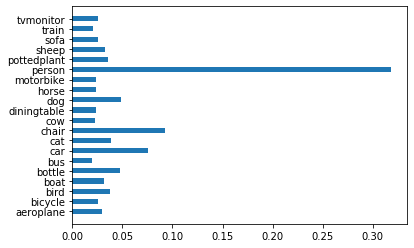

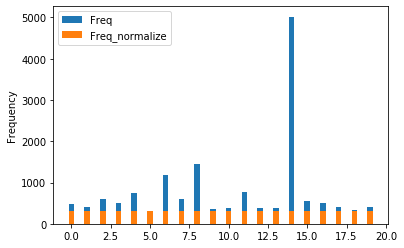

In [40]:
labels, freq = get_frequency_from_generator(train_gen)
plot_label_frequency(labels, freq)
freq_normalize, weigh = normalize_frequency(freq)
#plot_label_frequency(labels, freq_normalize)
plot_stacked_bar_freq(labels, freq, freq_normalize)

# dict for weigh model
weigh_class = {}
for label,i in zip(labels, weigh):
  weigh_class[from_label_to_number(mapping, label)] = i

from sklearn.utils import class_weight

weigh_class_sklearn = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_gen.classes),
                                                 train_gen.classes)


## Focal loss

In [0]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

## Set up iper-parameter for fit

In [0]:
loss = 'categorical_crossentropy'
optimizer = 'adam'
reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, 
                                      verbose=1, mode='auto', min_delta=0.0001, 
                                      cooldown=0, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1
                           )
metrics = ['categorical_accuracy']
epochs = 30
steps_per_epoch = ceil(train_gen.n/BATCH_SIZE)
validation_steps = ceil(val_gen.n/BATCH_SIZE)
class_weight = weigh_class
dense = [256, 256]

In [99]:
model = create_model( base_net=base_net, 
                      freeze_all=True, 
                      freeze_to=0, 
                      dense=dense,
                      dropout=0.3,
                      im_size=IM_SIZE
                     )

model.summary()

model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics
              )

net_history = model.fit_generator(train_gen, epochs=epochs, verbose=1,
                                  validation_data = val_gen,
                                  steps_per_epoch = steps_per_epoch,
                                  validation_steps = validation_steps,
                                  callbacks = [early_stop],
                                  #class_weight = class_weight
                                  )

Epoch 1/30
247/247 [==============================] - 197s 796ms/step - loss: 1.4561 - categorical_accuracy: 0.5710 - val_loss: 1.1792 - val_categorical_accuracy: 0.6400
Epoch 2/30
247/247 [==============================] - 181s 733ms/step - loss: 0.8215 - categorical_accuracy: 0.7467 - val_loss: 1.0382 - val_categorical_accuracy: 0.6870
Epoch 3/30
247/247 [==============================] - 181s 732ms/step - loss: 0.5699 - categorical_accuracy: 0.8179 - val_loss: 1.1313 - val_categorical_accuracy: 0.6722
Epoch 4/30
247/247 [==============================] - 181s 733ms/step - loss: 0.4137 - categorical_accuracy: 0.8692 - val_loss: 1.3497 - val_categorical_accuracy: 0.6459
Epoch 5/30
247/247 [==============================] - 181s 733ms/step - loss: 0.3052 - categorical_accuracy: 0.9035 - val_loss: 1.3188 - val_categorical_accuracy: 0.6759
Epoch 00005: early stopping
